In [0]:
import tensorflow as tf
from tensorflow import nn
from tensorflow.nn import rnn_cell
import numpy as np
import matplotlib.pyplot as plt
tf.reset_default_graph()

In [0]:
import midi
import numpy as np


lowerBound = 24
upperBound = 102
span = upperBound-lowerBound


def midiToNoteStateMatrix(midifile, squash=True, span=span):
	pattern = midi.read_midifile(midifile)
	
	timeleft = [track[0].tick for track in pattern]
	
	posns = [0 for track in pattern]
	
	statematrix = []
	time = 0
	
	state = [[0,0] for x in range(span)]
	statematrix.append(state)
	condition = True
	while condition:
		if time % (pattern.resolution / 4) == (pattern.resolution / 8):
			# Crossed a note boundary. Create a new state, defaulting to holding notes
			oldstate = state
			state = [[oldstate[x][0],0] for x in range(span)]
			statematrix.append(state)
		for i in range(len(timeleft)): #For each track
			if not condition:
				break
			while timeleft[i] == 0:
				track = pattern[i]
				pos = posns[i]
				
				evt = track[pos]
				if isinstance(evt, midi.NoteEvent):
					if (evt.pitch < lowerBound) or (evt.pitch >= upperBound):
						pass
						# print "Note {} at time {} out of bounds (ignoring)".format(evt.pitch, time)
					else:
						if isinstance(evt, midi.NoteOffEvent) or evt.velocity == 0:
							state[evt.pitch-lowerBound] = [0, 0]
						else:
							state[evt.pitch-lowerBound] = [1, 1]
				elif isinstance(evt, midi.TimeSignatureEvent):
					if evt.numerator not in (2, 4):
						# We don't want to worry about non-4 time signatures. Bail early!
						# print "Found time signature event {}. Bailing!".format(evt)
						out =  statematrix
						condition = False
						break
				try:
					timeleft[i] = track[pos + 1].tick
					posns[i] += 1
				except IndexError:
					timeleft[i] = None
			
			if timeleft[i] is not None:
				timeleft[i] -= 1
		
		if all(t is None for t in timeleft):
			break
		
		time += 1
	S = np.array(statematrix)
	statematrix = np.hstack((S[:, :, 0], S[:, :, 1]))
	statematrix = np.asarray(statematrix)
	one_hot_matrix = np.array([1 if S[i][j].any() else 0 for i in range(len(S)) for j in range(len(S[i]))]).reshape((S.shape[0], S.shape[1]))
	return one_hot_matrix

def noteStateMatrixToMidi(statematrix, name="example", span=span):
	statematrix = np.array(statematrix)
	pattern = midi.Pattern()
	track = midi.Track()
	pattern.append(track)
	
	span = upperBound-lowerBound
	tickscale = 55
	
	lastcmdtime = 0
	prevstate = [0 for x in range(span)]
	for time, state in enumerate(statematrix + [prevstate[:]]):  
		offNotes = []
		onNotes = []
		for i in range(span):
			n = state[i]
			p = prevstate[i]
			if p == 1:
				if n == 0:
					offNotes.append(i)
			elif n == 1:
				onNotes.append(i)
		for note in offNotes:
			track.append(midi.NoteOffEvent(tick=(time-lastcmdtime)*tickscale, pitch=note+lowerBound))
			lastcmdtime = time
		for note in onNotes:
			track.append(midi.NoteOnEvent(tick=(time-lastcmdtime)*tickscale, velocity=40, pitch=note+lowerBound))
			lastcmdtime = time
		
		prevstate = state
	
	eot = midi.EndOfTrackEvent(tick=1)
	track.append(eot)
	
	midi.write_midifile("{}.mid".format(name), pattern)



In [0]:
from util import print_progress

import numpy as np
import glob


def create_dataset(min_length):
    songs = glob.glob('*.mid*')
    
    encoded_songs = []
    discarded = 0
    for song in songs:
        encoded_song = midiToNoteStateMatrix(song)
        encoded_song = make_one_hot_notes(encoded_song)
        if len(encoded_song) >= min_length:
            encoded_songs.append(encoded_song)
        else:
            discarded += 1
    print("{} songs processed".format(len(songs)))
    print("{} songs discarded".format(discarded))
    return encoded_songs

def make_one_hot_notes(song):
    """
    Makes the song one_hot by choosing the highest note 
    from each chord (presumably the melody)
    """
    new_song = np.zeros(song.shape)
    for i in range(len(song)):
        nonzeros = np.nonzero(song[i])
        if len(nonzeros[0]) > 0:
            new_song[i, nonzeros[0][-1]] = 1
    return new_song


def get_batch(encoded_songs, batch_size, timesteps, input_size, output_size):
    
    rand_song_indices = np.random.randint(len(encoded_songs), size=batch_size)
    batch_x = np.zeros((batch_size, timesteps, input_size))
    batch_y = np.zeros((batch_size, output_size))
    for i in range(batch_size):
        song_ind = rand_song_indices[i]
        start_ind = np.random.randint(encoded_songs[song_ind].shape[0]-timesteps-1)
        batch_x[i] = encoded_songs[song_ind][start_ind:start_ind+timesteps]
        batch_y[i] = encoded_songs[song_ind][start_ind+timesteps]
    return batch_x, batch_y


In [0]:
min_song_length=128
encoded_songs=create_dataset(min_song_length)

88 songs processed
15 songs discarded


In [0]:
NUM_SONGS=len(encoded_songs)
print(str(NUM_SONGS)+" total Number of Songs to learn from")
print(encoded_songs[0].shape)

73 total Number of Songs to learn from
(257, 78)


In [0]:
#NN parameters
input_size=encoded_songs[0].shape[1]   #number of Notes
output_size=input_size
hidden_size=128                  #number of neurons in hidden layer

learning_rate=0.001
training_steps=200 #number of batches during training
batch_size=64 #number of songs per batch
time_steps=64 #length of song snippet

assert time_steps < min_song_length

In [0]:
#model
input_placeholder_shape=[None,time_steps,input_size]
output_placeholder_shape=[None,output_size]

input_vec=tf.placeholder("float",input_placeholder_shape)
output_vec=tf.placeholder("float",output_placeholder_shape)      #For true Note

#weights
weights = tf.Variable(tf.random_normal([hidden_size,output_size]))

#biases
biases = tf.Variable(tf.random_normal([output_size]))

In [0]:
def RNN(input_vec,weights,biases):
  input_vec=tf.unstack(input_vec,time_steps,1) #to unstack the full input 3D vector leaving colunms till timesteps=64
  lstm_cell = rnn_cell.LSTMCell(hidden_size)
  outputs, states = tf.nn.static_rnn(lstm_cell, input_vec, dtype=tf.float32)
  recurrent_net = tf.matmul(outputs[-1],weights) + biases
  
  #prediction of next note to use it later
  prediction = tf.nn.softmax(recurrent_net)
  
  return recurrent_net, prediction

In [0]:
Logits,Prediction=RNN(input_vec,weights,biases)

In [0]:
#LOSS operation
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Logits, labels=output_vec))

In [0]:
#Training operation
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

In [0]:
#Acuracy operation
true_note = tf.argmax(output_vec,1)  #one hot max column return
pred_note = tf.argmax(Prediction,1)
correct_pred = tf.equal(pred_note,true_note)

accuracy_op=tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [0]:
#intializer
init=tf.global_variables_initializer()

In [0]:
#Train
#1) Launch the Session
sess = tf.InteractiveSession()
#2) Intialize the Variables
sess.run(init)
#3) Train
display_step=1
for step in range(training_steps):
  batch_x, batch_y = get_batch(encoded_songs, batch_size, time_steps, input_size, output_size)
  
  feed_dict = {
      input_vec: batch_x,
      output_vec: batch_y
  }
  
  sess.run(train_op,feed_dict)
  
  if step % display_step==0 or step==1:
    loss, acc=sess.run([loss_op,accuracy_op],feed_dict)
    suffix = "\nStep " + str(step) + ", Minibatch Loss= " + \
                 "{:.4f}".format(loss) + ", Training Accuracy= " + \
                 "{:.3f}".format(acc)
    print_progress(step, training_steps, barLength=50, suffix=suffix)

 |--------------------------------------------------| 0.0% 
 |--------------------------------------------------| 0.5% 
 |=-------------------------------------------------| 1.0% 
 |=-------------------------------------------------| 1.5% 
 |=-------------------------------------------------| 2.0% 
 |=-------------------------------------------------| 2.5% 
 |==------------------------------------------------| 3.0% 
 |==------------------------------------------------| 3.5% 
 |==------------------------------------------------| 4.0% 
 |==------------------------------------------------| 4.5% 
 |===-----------------------------------------------| 5.0% 
 |===-----------------------------------------------| 5.5% 
 |===-----------------------------------------------| 6.0% 
 |===-----------------------------------------------| 6.5% 
 |====----------------------------------------------| 7.0% 
 |====----------------------------------------------| 7.5% 
 |====----------------------------------

47
47
48
48
47
47
47
47
47
47
47
47
47
47
47
45
45
45
45
50
44
45
45
45
45
45
45
45
45
45
45
45
50
50
50
45
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
45
48
48
48
48
48
48
48
48
48
48
45
47
45
48
47
47
47
48
48
45
45
45
45
45
45
48
48
48
45
45
45
45
47
50
50
50
48
48
48
48
48
48
48
48
48
47
45
45
45
45
45
48
48
48
48
48
48
52
47
47
47
47
47
47
47
47
47
47
47
47
45
45
48
47
45
48
47
47
48
48
48
48
50
50
50
52
52
52
43
48
41
41
41
50
41
41
48
48
48
48
41
41
52
48
41
41
41
41
41
41
41
41
41
43
48
40
40
40
41
41
43
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
43
40
40
40
40
40
40
40
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
40
40
40
41
43
43
41
43
43
43
43
43
43
43
43
41
41
41
41
41
41
41
41
41
41
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
40
43
40
40
36
40
40
36
36
36
40
40
40
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
4

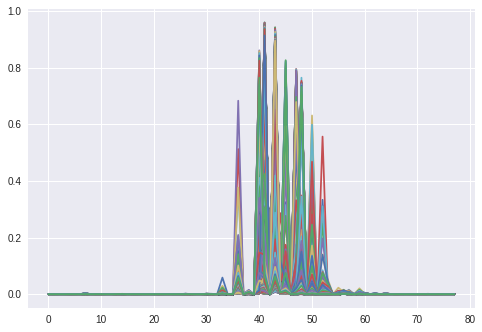

In [0]:
GEN_SEED_RANDOMLY = False # Use a random snippet as a seed for generating the new song.
if GEN_SEED_RANDOMLY:
    ind = np.random.randint(NUM_SONGS)
else:
    ind = 41 # "How Deep is Your Love" by Calvin Harris as a starting seed
    
gen_song = encoded_songs[ind][:time_steps].tolist() # TODO explore different (non-random) seed options
    
# generate music!
for i in range(500):
    seed = np.array([gen_song[-time_steps:]])
    # Use our RNN for prediction using our seed! 
    '''TODO: Write an expression to use the RNN to get the probability for the next note played based on the seed.
    Remember that we are now using the RNN for prediction, not training.'''
    predict_probs = sess.run(Prediction, feed_dict = {input_vec:seed}) # TODO

    # Define output vector for our generated song by sampling from our predicted probability distribution
    played_notes = np.zeros(output_size)
    '''TODO: Sample from the predicted distribution to determine which note gets played next.
    You can use a function from the numpy.random library to do this.
    Hint 1: range(x) produces a list of all the numbers from 0 to x
    Hint 2: make sure predict_probs has the "shape" you expect. you may need to flatten it: predict_probs.flatten()'''
    print np.argmax(predict_probs[0])
    plt.plot(predict_probs[0])
    sampled_note = np.random.choice(range(output_size), p=predict_probs[0]) # TODO
    #sampled_note = np.argmax(predict_probs[0])
    played_notes[sampled_note] = 1
    gen_song.append(played_notes)

noteStateMatrixToMidi(gen_song, name="gen_song_0")
noteStateMatrixToMidi(encoded_songs[ind], name="base_song_0")
print("saved generated song! seed ind: {}".format(ind))